In [ ]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive',force_remount=False)

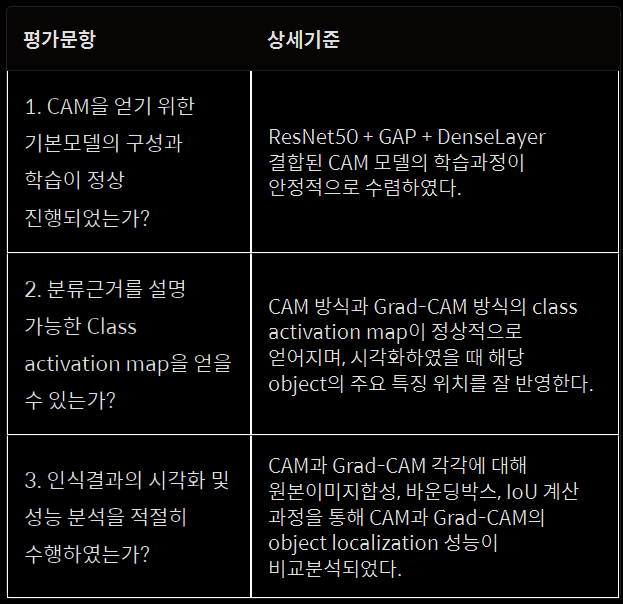

# 1. 라이브러리 준비 및 버전 확인

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
import os
import PIL
from PIL import Image

print("Tensorflow version : ",tf.__version__)
print("Numpy version : ", np.__version__)
print("CV2 version : ", cv2.__version__)
print("PIL version : ", PIL.__version__)

Tensorflow version :  2.8.0
Numpy version :  1.21.5
CV2 version :  4.1.2
PIL version :  7.1.2


## GPU 확인

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## DATASET 준비

In [3]:
# 최초 수행시에는 다운로드가 진행됩니다. 오래 걸릴 수 있으니 유의해 주세요.  
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)
print('Dataset 저장 완료')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteEQST9T/stanford_dogs-train.tfrecord


  0%|          | 0/12000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteEQST9T/stanford_dogs-test.tfrecord


  0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.
Dataset 저장 완료


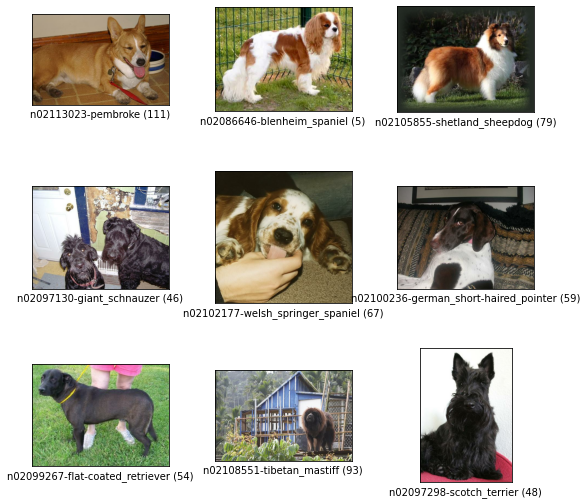

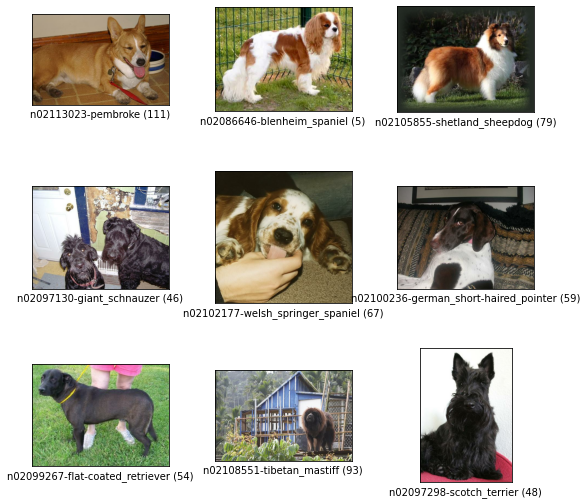

In [4]:
tfds.show_examples(ds_train, ds_info)

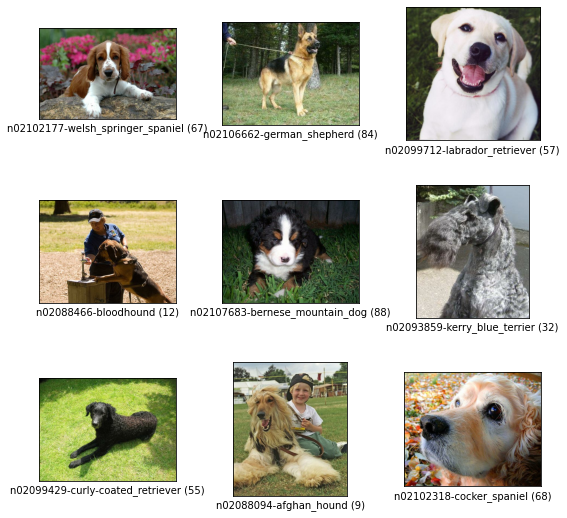

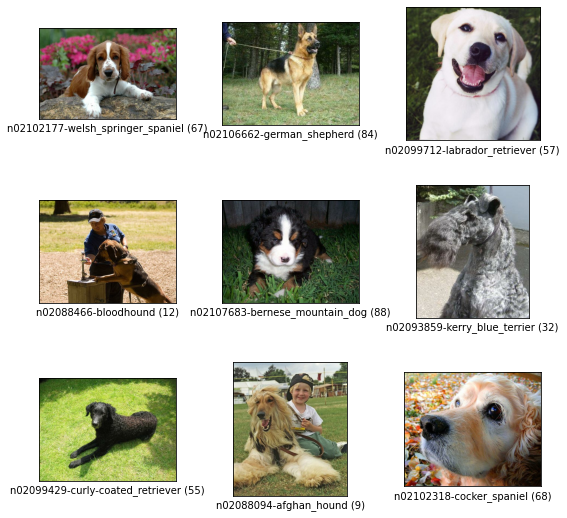

In [5]:
tfds.show_examples(ds_test, ds_info)

In [6]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

# 2. CAM 구현하기

● CNN 이후 fully connected layer 대신 GAP(Global Average Pooling)을 연산.   

● GAP(Global Average Pooling) :  매 채널별로, average pooling을 채널의 값 전체에 global하게 적용

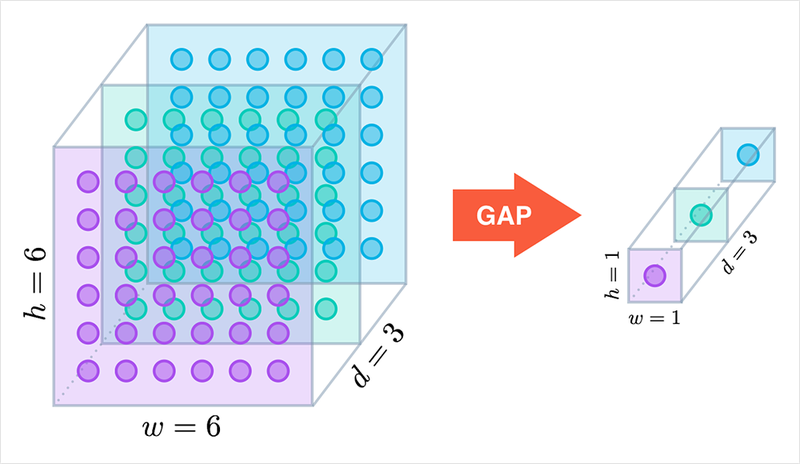

 ● GAP 연산을 하고, 그 연산 결과에 소프트맥스 활성화 함수를 적용 (overfitting 방지)

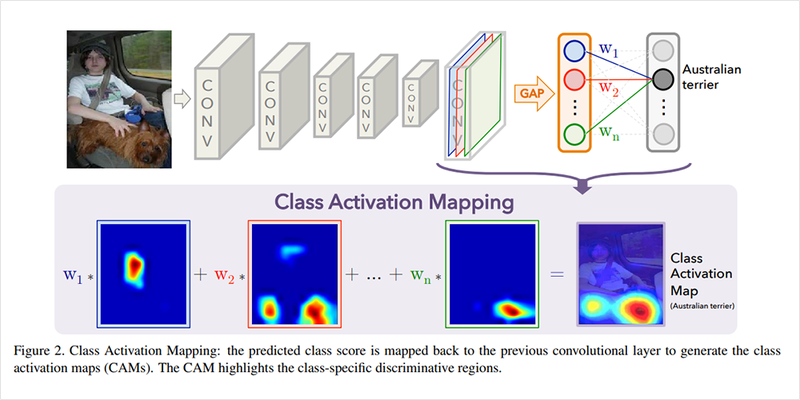

### 2-1. CAM 함수생성

#### ResNet50 뒤에 필요한 레이어를 붙여 CAM을 구하기 위한 기본 모델

In [7]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,     # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224,3),
    pooling='avg',      # GAP를 적용  
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

94781440/94765736 [==============================] - 0s 0us/step


In [8]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

 #### DATA 전처리 : normalizing과 resizing

In [9]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

print('완료')

완료


In [10]:
# 데이터셋에 전처리와 배치처리를 적용합니다. 
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


#### Data 학습

In [11]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

print('완료')

완료


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [12]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=10,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
750/750 [==============================] - 178s 216ms/step - loss: 2.2331 - accuracy: 0.4425 - val_loss: 3.1289 - val_accuracy: 0.2493
Epoch 2/10
750/750 [==============================] - 161s 215ms/step - loss: 0.6963 - accuracy: 0.8130 - val_loss: 1.1564 - val_accuracy: 0.6559
Epoch 3/10
750/750 [==============================] - 161s 215ms/step - loss: 0.1957 - accuracy: 0.9636 - val_loss: 0.9944 - val_accuracy: 0.7090
Epoch 4/10
750/750 [==============================] - 162s 216ms/step - loss: 0.0501 - accuracy: 0.9974 - val_loss: 0.9206 - val_accuracy: 0.7375
Epoch 5/10
750/750 [==============================] - 162s 216ms/step - loss: 0.0214 - accuracy: 0.9992 - val_loss: 0.9245 - val_accuracy: 0.7395
Epoch 6/10
750/750 [==============================] - 162s 216ms/step - loss: 0.0135 - accuracy: 1.0000 - val_loss: 0.9377 - val_accuracy: 0.7451
Epoch 7/10
750/750 [==============================] - 162s 215ms/step - loss: 0.0098 - accuracy: 1.0000 - val_loss: 0.9453 -

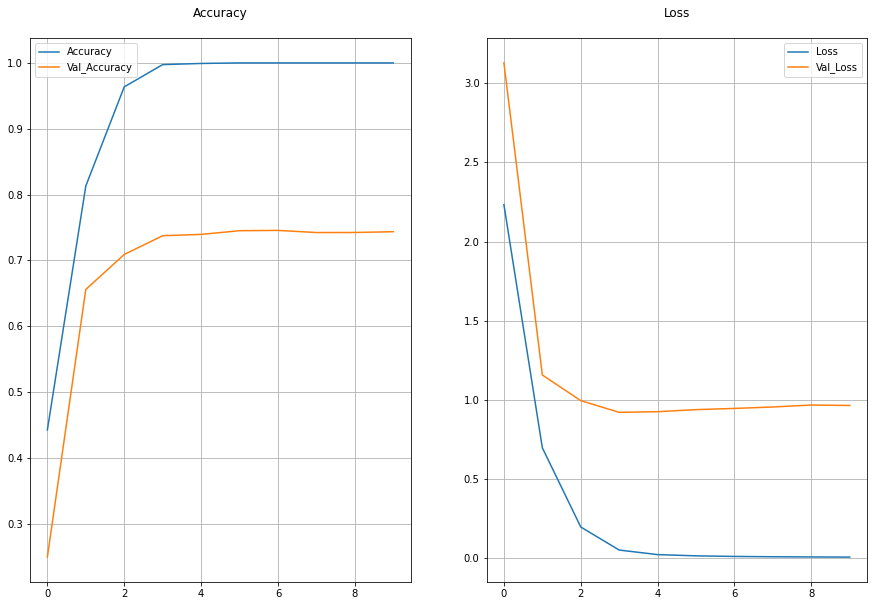

In [69]:
plt.figure(figsize=(15,10))
plt.subplot(1, 2, 1)
plt.plot(history_cam_model.history['accuracy'])
plt.plot(history_cam_model.history['val_accuracy'])
plt.title('Accuracy\n')
plt.legend(['Accuracy', 'Val_Accuracy'])
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(history_cam_model.history['loss'])
plt.plot(history_cam_model.history['val_loss'])
plt.title('Loss\n')
plt.legend(['Loss', 'Val_Loss'])
plt.grid()
plt.show()

In [13]:
cam_model_path = '/content/cam_model.h5'
cam_model.save(cam_model_path)
print("저장 완료!")

저장 완료!


## 2-2. CAM 이미지 생성

#### 데이터셋에서 한 장씩 뽑을 수 있도록 get_one() 함수 생성

In [14]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

print('완료')

완료


#### 데이터셋 get_one() 함수 적용하여 한장 Pick

40


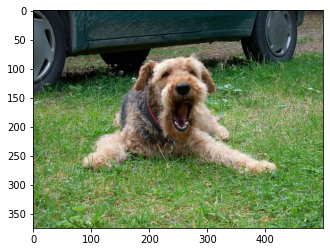

In [15]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

#### model과 item을 받았을 때 입력 이미지와 동일한 크기의 CAM을 반환하는 함수   
- CAM을 입력 이미지 사이즈와 같게 만들어 함께 시각화

In [16]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0] #마지막 모델의 weight activation을 가져옵니다.
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # W * f 를 통해 class별 activation map을 계산합니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

print('완료')

완료


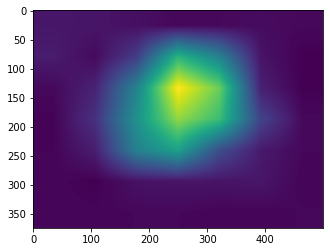

In [17]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

## 2-3. 원본과 CAM을 겹치기

In [18]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

print('겹치기 함수생성')

겹치기 함수생성


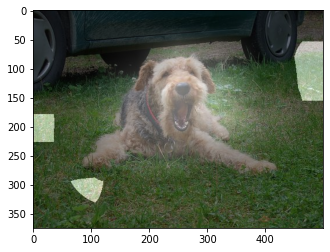

In [19]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

# 6. Grad-CAM 구현하기

### 6-1. 새로운 이미지

80


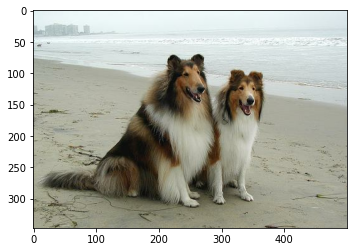

In [20]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

### 6-2. Grad-CAM 함수 생성
**grad_cam**

관찰을 원하는 layer와 정답 클래스에 대한 예측값 사이의 gradient를 구한 후 GAP을 적용.   
channel별 weights를 구함.   
구한 weights와 channel별 feature map을 convolusion하여 cam image를 얻음

In [38]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 class별 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # 각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

print('완료')

완료


### 6-3. 각 layer별 CAM images

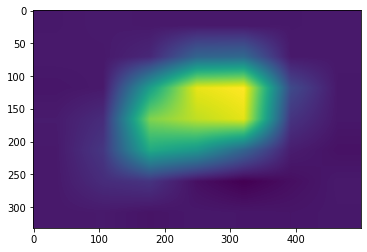

In [39]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

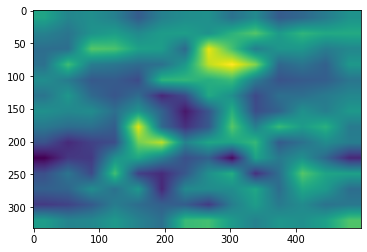

In [40]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

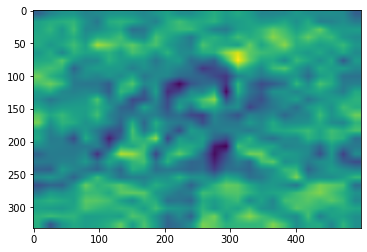

In [41]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

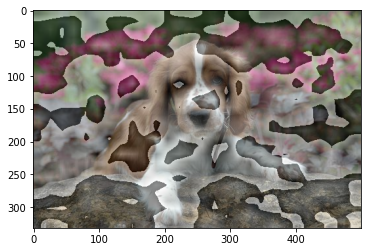

In [42]:
# conv3_block3_out
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

# 7. 바운딩 박스 구하기

108


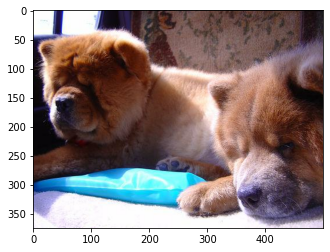

In [43]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

## 7-1. CAM B-BOX

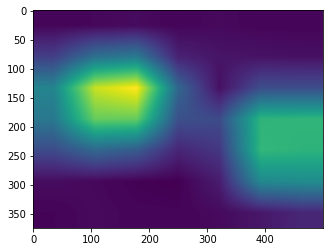

In [44]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [45]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

print('함수생성 완료')

함수생성 완료


In [46]:
rect = get_bbox(cam_image)
rect

array([[495, 391],
       [-44, 297],
       [  7,   0],
       [547,  94]])

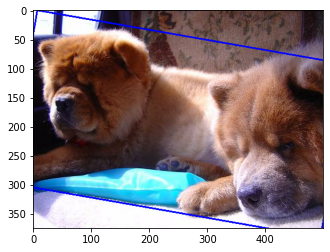

In [48]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

## 7-2. Grad-CAM B-BOX

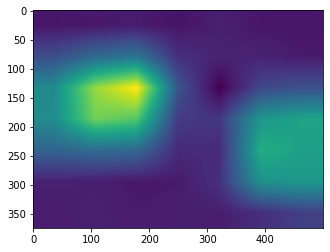

In [51]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

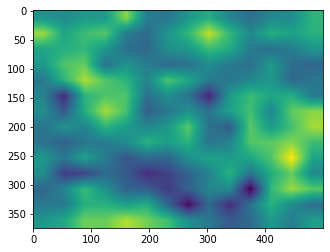

In [53]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

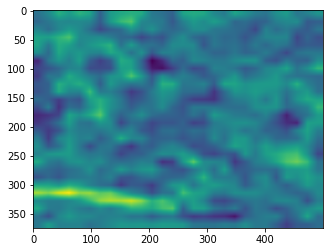

In [54]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

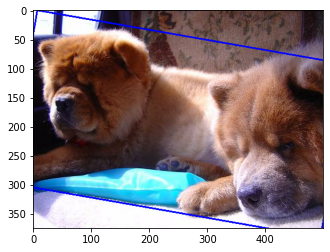

In [52]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

# 8. IoU 구하기   
IoU(Intersection over Union) :  두 영역의 교집합인 intersection 영역의 넓이를 두 영역의 합집합인 union 영역으로 나누어준 값

In [55]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

print('함수 생성 완료')

함수 생성 완료


### Ground truth와 예측값 바운딩 박스(prediction box) 두 가지를 이용해서 IoU를 계산

In [58]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

print('함수 생성 완료')

함수 생성 완료


#### 동일한 이미지에 CAM 적용시 Bounding box 및 IoU

In [70]:
cam_image = generate_cam(cam_model, item)
rect = get_bbox(cam_image)

In [71]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.0, -0.088, 1.0426666666666666, 1.094]

In [72]:
item['objects']['bbox']

array([[0.13066667, 0.488     , 0.96533334, 0.998     ],
       [0.072     , 0.        , 0.784     , 0.678     ]], dtype=float32)

In [73]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.34539835196467356

#### 동일한 이미지에 Grad-CAM 적용시 Bounding box 및 IoU

In [74]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
rect = get_bbox(grad_cam_image)

In [75]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.0, -0.094, 1.056, 1.1]

In [76]:
item['objects']['bbox']

array([[0.13066667, 0.488     , 0.96533334, 0.998     ],
       [0.072     , 0.        , 0.784     , 0.678     ]], dtype=float32)

In [77]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.33760975149463107

# 9. 결과 및 회고   
IOU_CAM= 0.345    
IUC_Grad_CAM = 0.338

두개의 모델이 육안으로 확인하기 힘들정도로 Bounding Box가 동일한거 같으며 많은 차이가 없는 IOU로도 확인할 수 있다. 모델학습은 10 epoch으로 하였지만 5 epoch으로 높은 Accuracy에 도달한 것을 확인할 수 있었으며 따라서 실제 활용이 많이되고 있으이라 예측된다. 이번 Theme는 개념적으로 어렵지는 않았고 code도 길거나 어렵지 않아서 유익하였다.
